In [1]:
## imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno # used to visualize missing values in data 
import emoji
import spacy

nlp = spacy.load('en_core_web_sm')# loads  the  english  language  model

In [2]:
import nltk
import string
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-10-31 10:22:01.188962: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 10:22:01.438428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# importing models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalMaxPooling1D,Embedding,Dense,LSTM

from sklearn.metrics import accuracy_score

## EDA

In [5]:
## Getting the data

data = pd.read_csv("/media/danlof/dan files/data_science_codes/Project_3/reviews_data.csv")
data.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
dtypes: float64(1), object(5)
memory usage: 40.0+ KB


In [9]:
# checking how many missing values are in the data
data.isnull().sum()



name             0
location         0
Date             0
Rating         145
Review           0
Image_Links      0
dtype: int64

<Axes: >

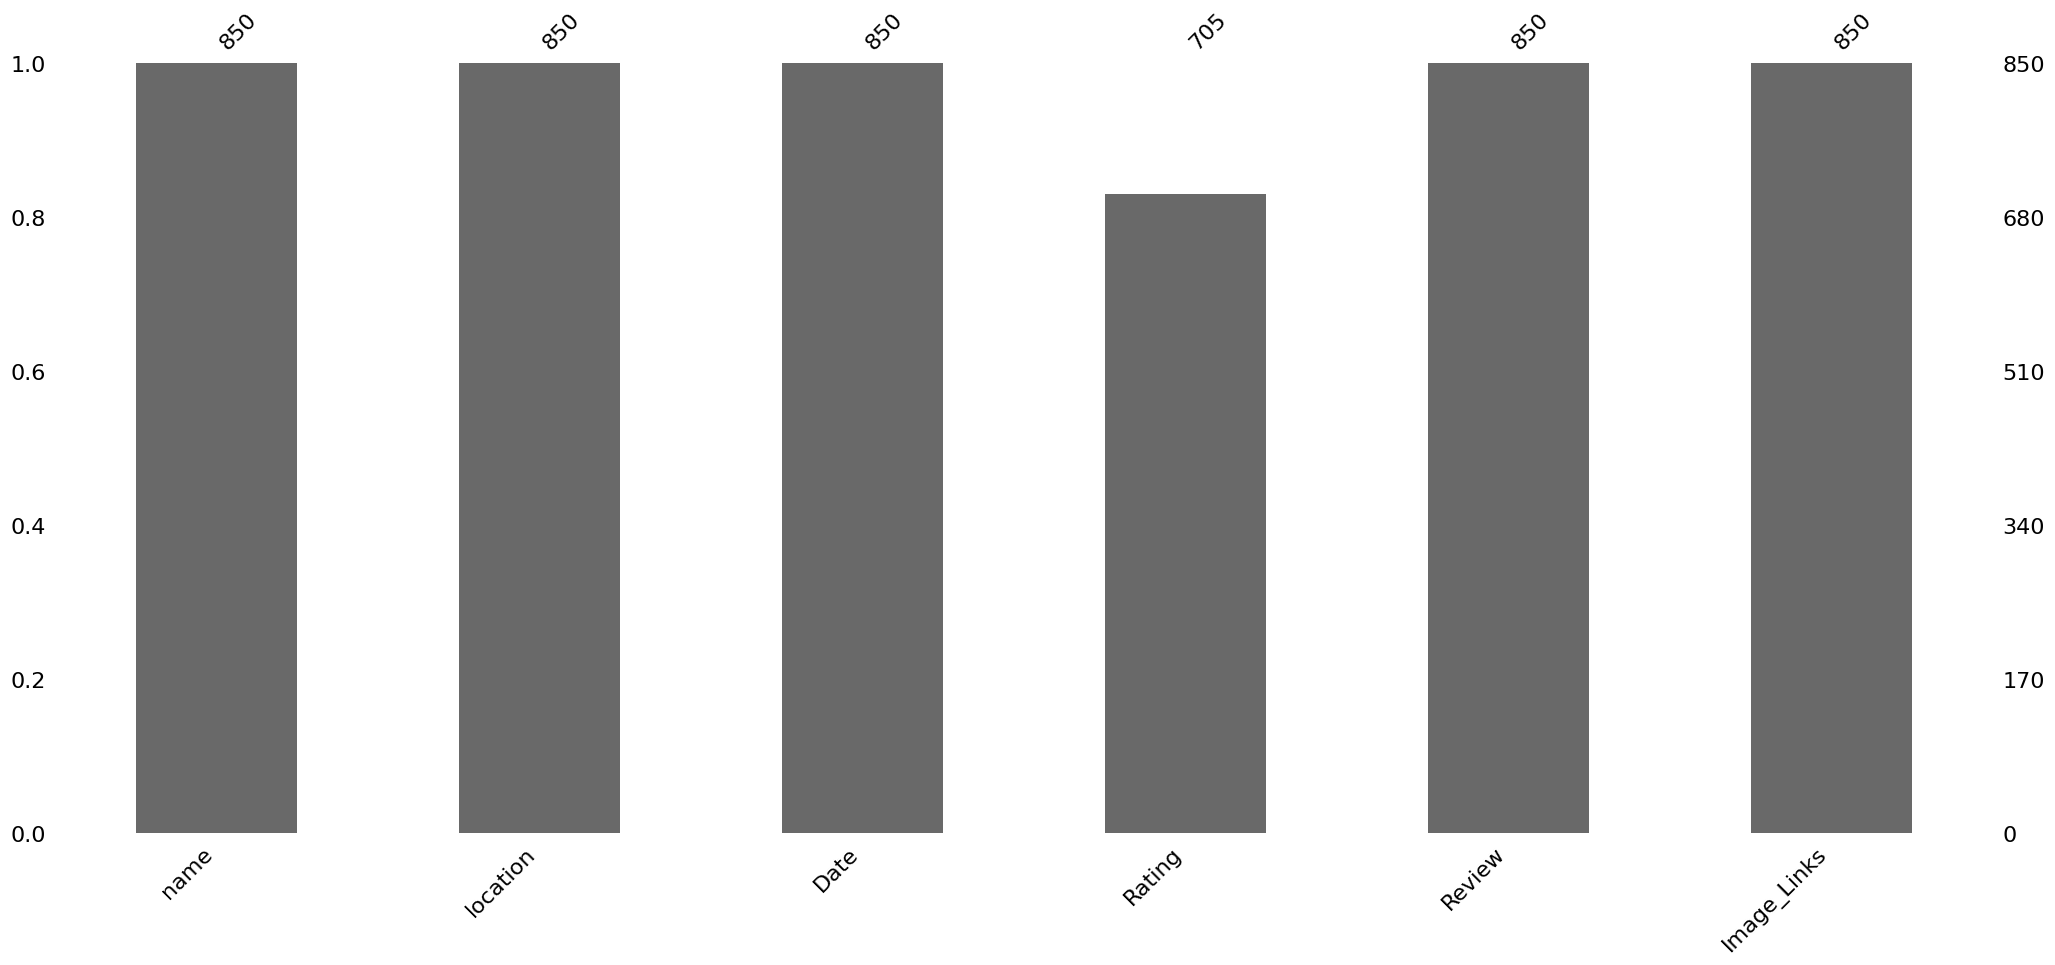

In [10]:
msno.bar(data)

- The above plot just adds emphasis to show missing values in the feature rating with 145 missing ,
- We shall drop them, since they are of no use to us, and including image_links 

## Dropping  

In [6]:
data.dropna(inplace = True)
data.drop(columns= ['Image_Links'],inplace = True)

### 1.Rating in details

<Axes: xlabel='Rating', ylabel='count'>

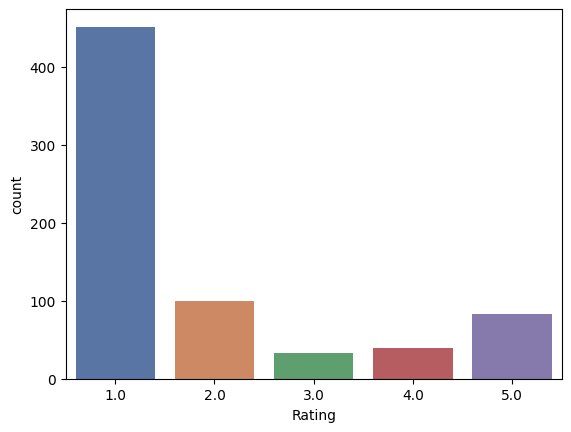

In [7]:
sns.countplot(x='Rating',data=data,palette='deep')


- In the palette above you can play with : dark,Set3,colorblind,pastel,deep

- From the plot above we can conclude that many ratings are on the negative side(1s),
- Suggesting that the company has to do something about that 

On rating still we shall have to classify them into 3 classes:
 - positive class - 1
 - negative class - 2
 - neutral class - 0

In [7]:
data['Rating'] = data['Rating'].replace([1,2],2) # negative class
data['Rating'] = data['Rating'].replace(3,0) # neutral class
data['Rating'] = data['Rating'].replace([4,5],1) # positive class
data = data.dropna(axis=0,how='any')
data['Rating'] = data['Rating'].astype(int)

In [9]:
data['Rating'].value_counts()

Rating
2    550
1    122
0     33
Name: count, dtype: int64

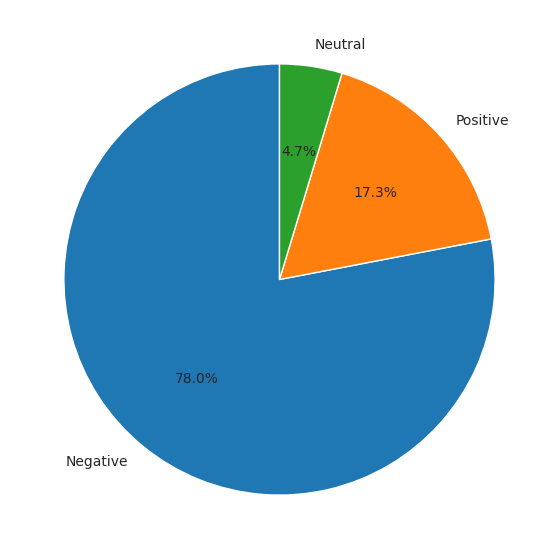

In [11]:
plt.figure(figsize=(7,7))
sns.set_style('whitegrid')
plt.pie(data['Rating'].value_counts(),labels=['Negative','Positive','Neutral'],autopct='%1.1f%%',startangle=90);

### 2.Location

- Here we are going to split and extract just the states 

In [8]:
data['location'] = data['location'].str.split(',').str[1]

- we can visualize the most common places of the reviews as follows

Text(0.5, 1.0, 'Count of reviews per state')

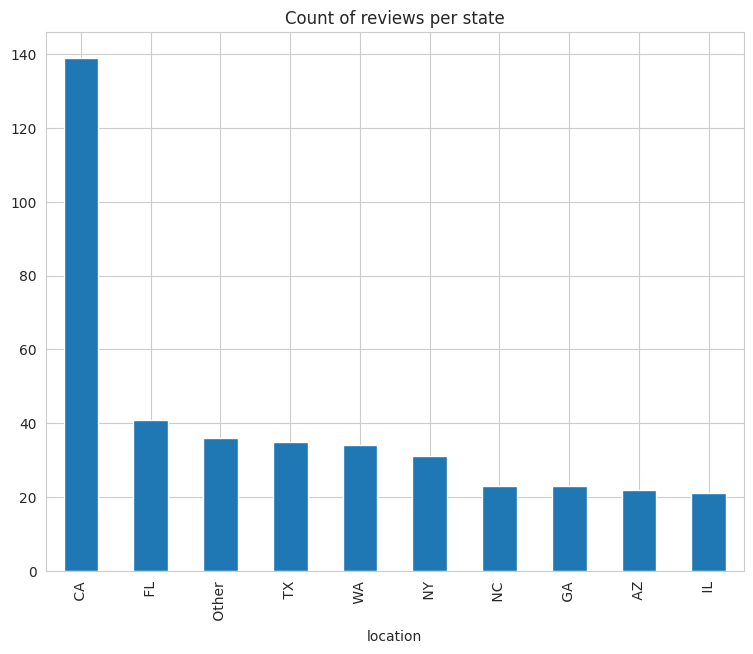

In [15]:
plt.figure(figsize=(9,7))
sns.set_style('whitegrid')
data['location'].value_counts().sort_values(ascending=False).head(10).plot.bar()
plt.title('Count of reviews per state')

- It can be seen that most of the reviews come from CA(California)
- we can explore to see if there is influence between locations and ratings 

### 2.1 Location/Rating

In [9]:
df = data[['location','Rating']]
df['Negative']=df[df['Rating']==2]['Rating']
df['Positive'] = df[df['Rating']==1]['Rating']
df['Neutral'] = df[df['Rating']==0]['Rating']
df.drop('Rating',axis=1,inplace=True)
df = df.groupby('location').count().sort_values(ascending = False,by='Negative').head(9)
df

,Negative,Positive,Neutral
location,,,
CA,111,20,8
FL,33,6,2
WA,29,3,2
NY,27,3,1
Other,26,8,2
TX,25,8,2
GA,21,2,0
NC,21,2,0
AZ,17,4,1


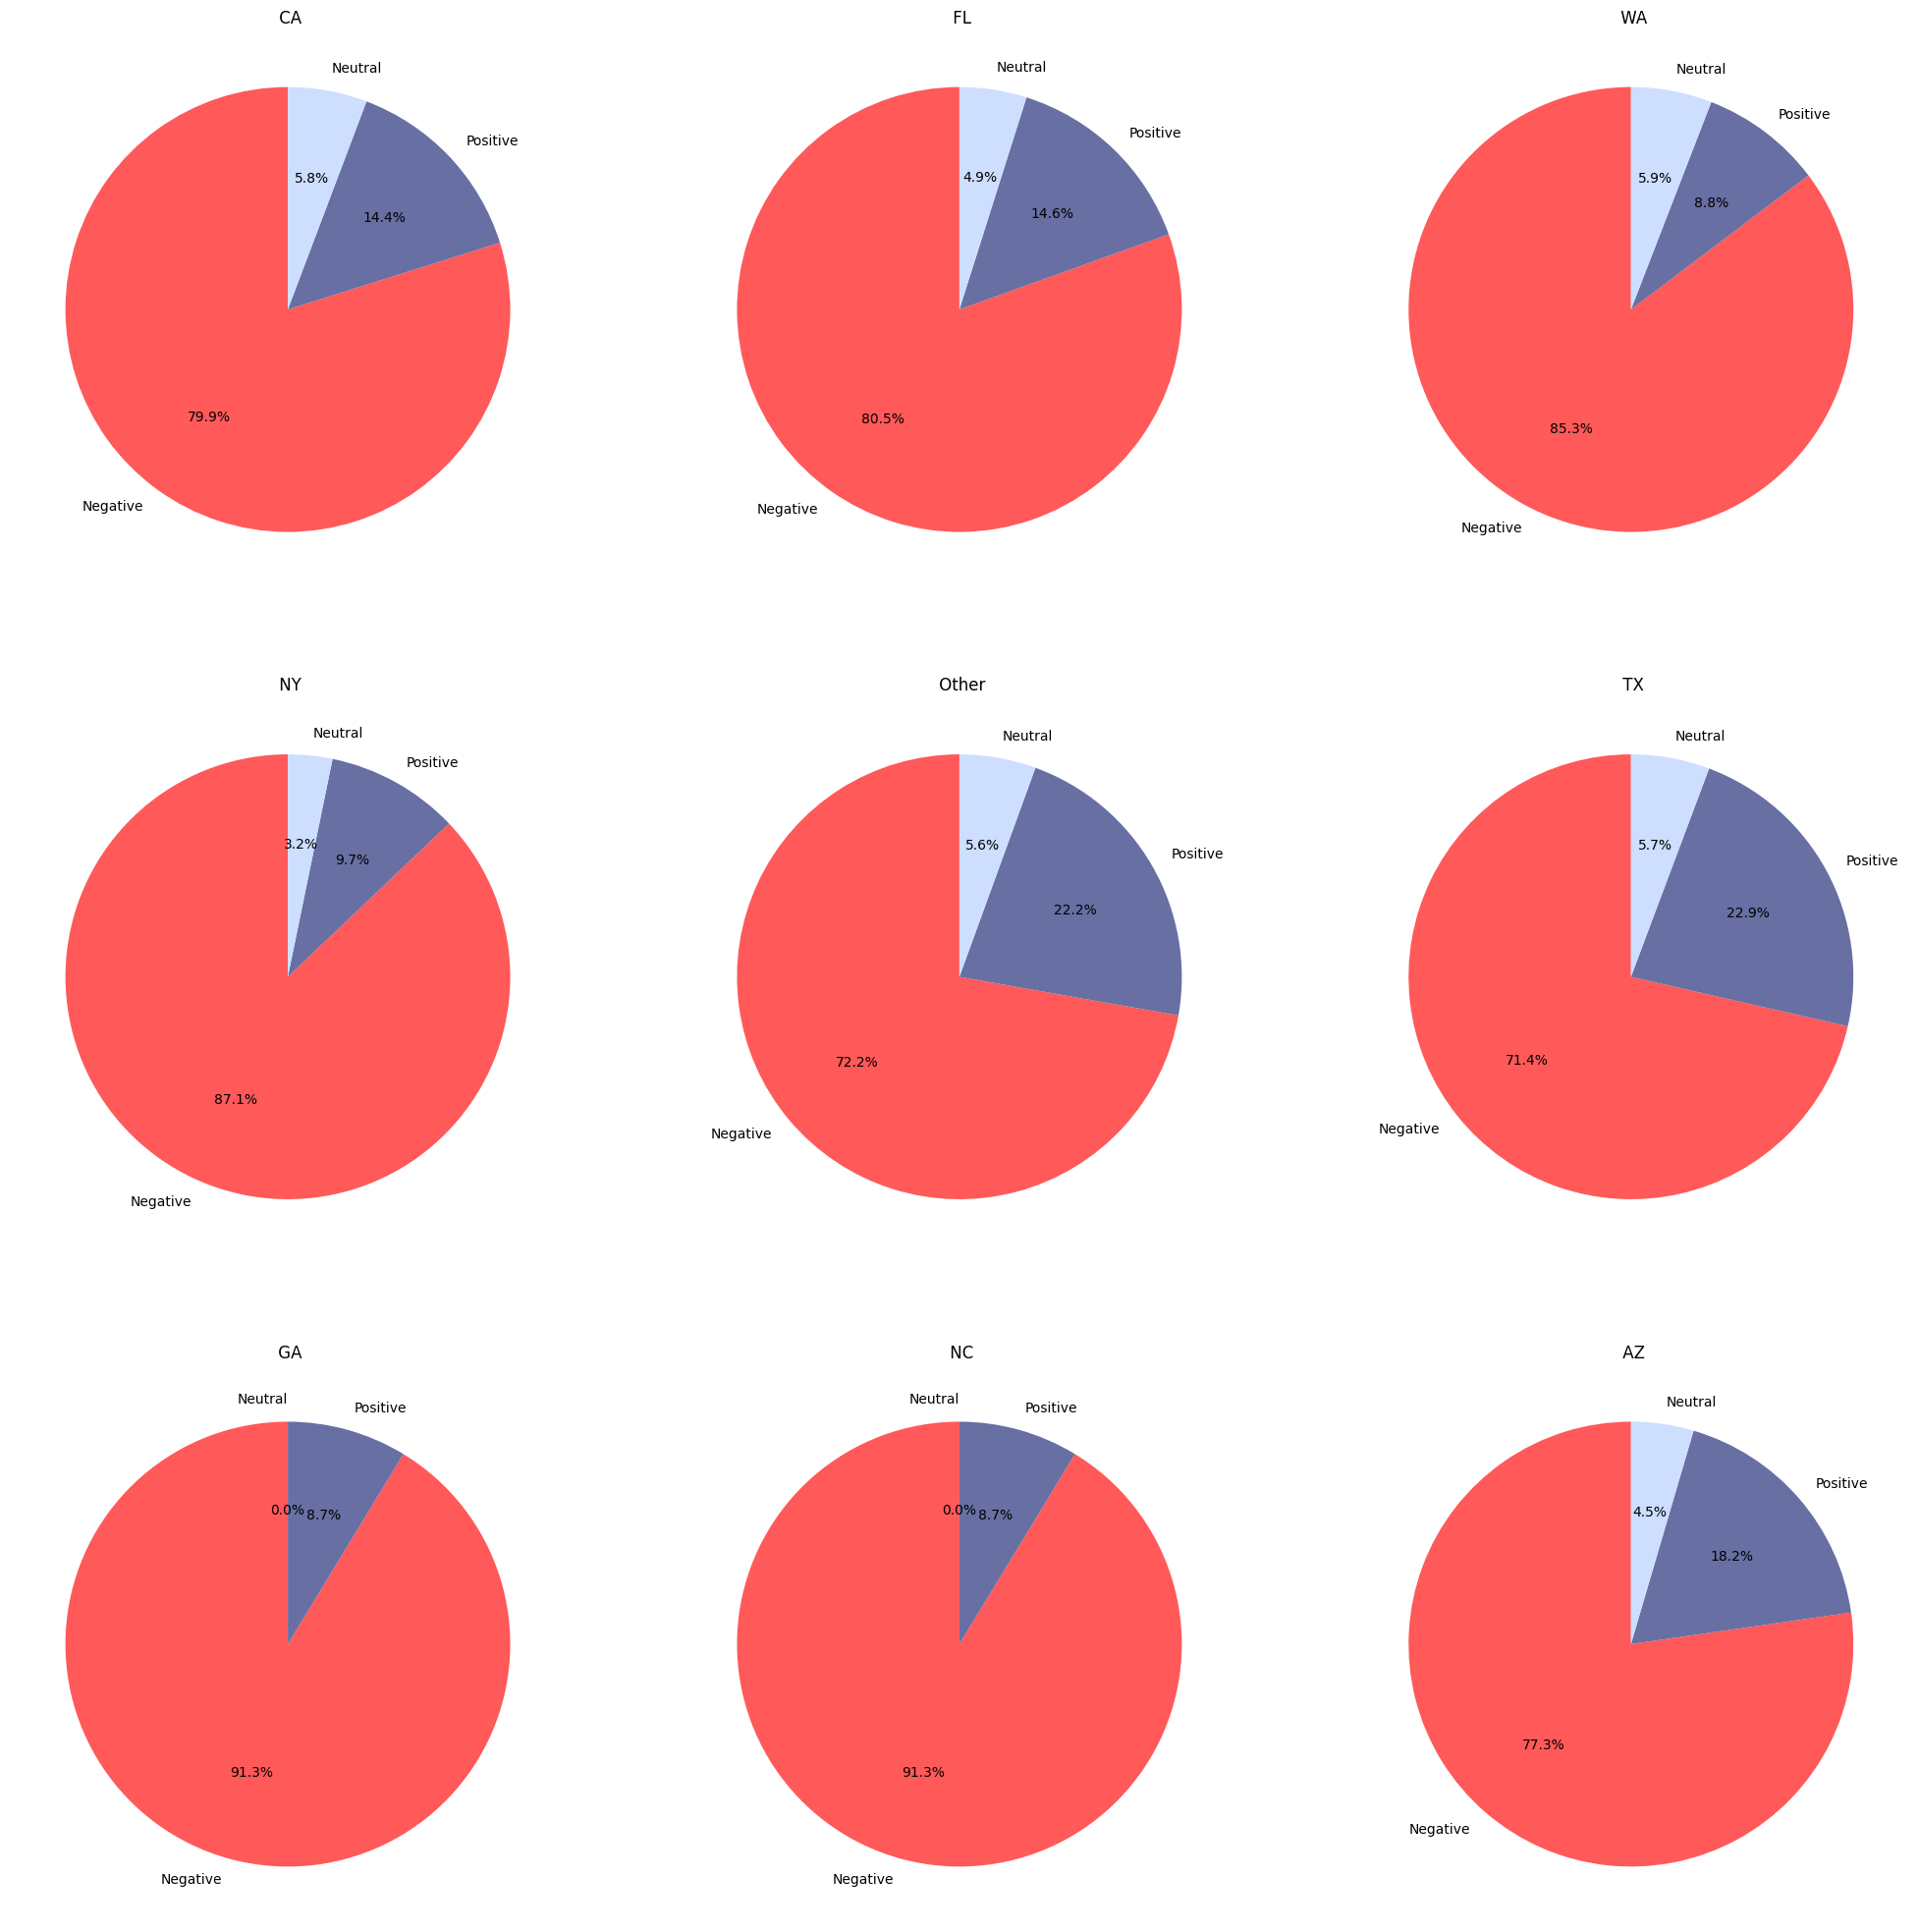

In [15]:
fig = plt.figure(figsize=(25,25))

i=1
features =  df.index

for x in features:
    plt.subplot(3,3,i)
    ax = plt.pie(df.loc[x],labels = df.columns,autopct='%1.1f%%',startangle=90,
                colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x),loc='center')
    i+=1



- 4 of the negative ratings are from the east coast in the states of Georgia,North carolina,New york and Florida,
- 2 are on the west coast in the states of Washington and California


### 3.Name

In [20]:
df = data[['name','Rating']]

# we are filtering the Rating columns based on the different conditions (1,2,0)
# then we make a new column(s) of the same(negative...)
# a 
df['Negative'] = df[df['Rating']==2]['Rating']# this last past part changes the boleen return to actual values
df['Positive'] = df[df['Rating']==1]['Rating']
df['Neutral'] = df[df['Rating']==0]['Rating']
df.drop('Rating',axis=1,inplace = True)
df = df.groupby('name').count().sort_values(ascending=False,by='Negative').head(9)
df

,Negative,Positive,Neutral
name,,,
Linda,8,2,1
Kelly,7,0,0
Michael,6,1,0
Mark,5,0,0
David,5,1,1
Karen,4,1,0
Jill,4,0,0
Steven,4,0,0
Chris,4,0,0


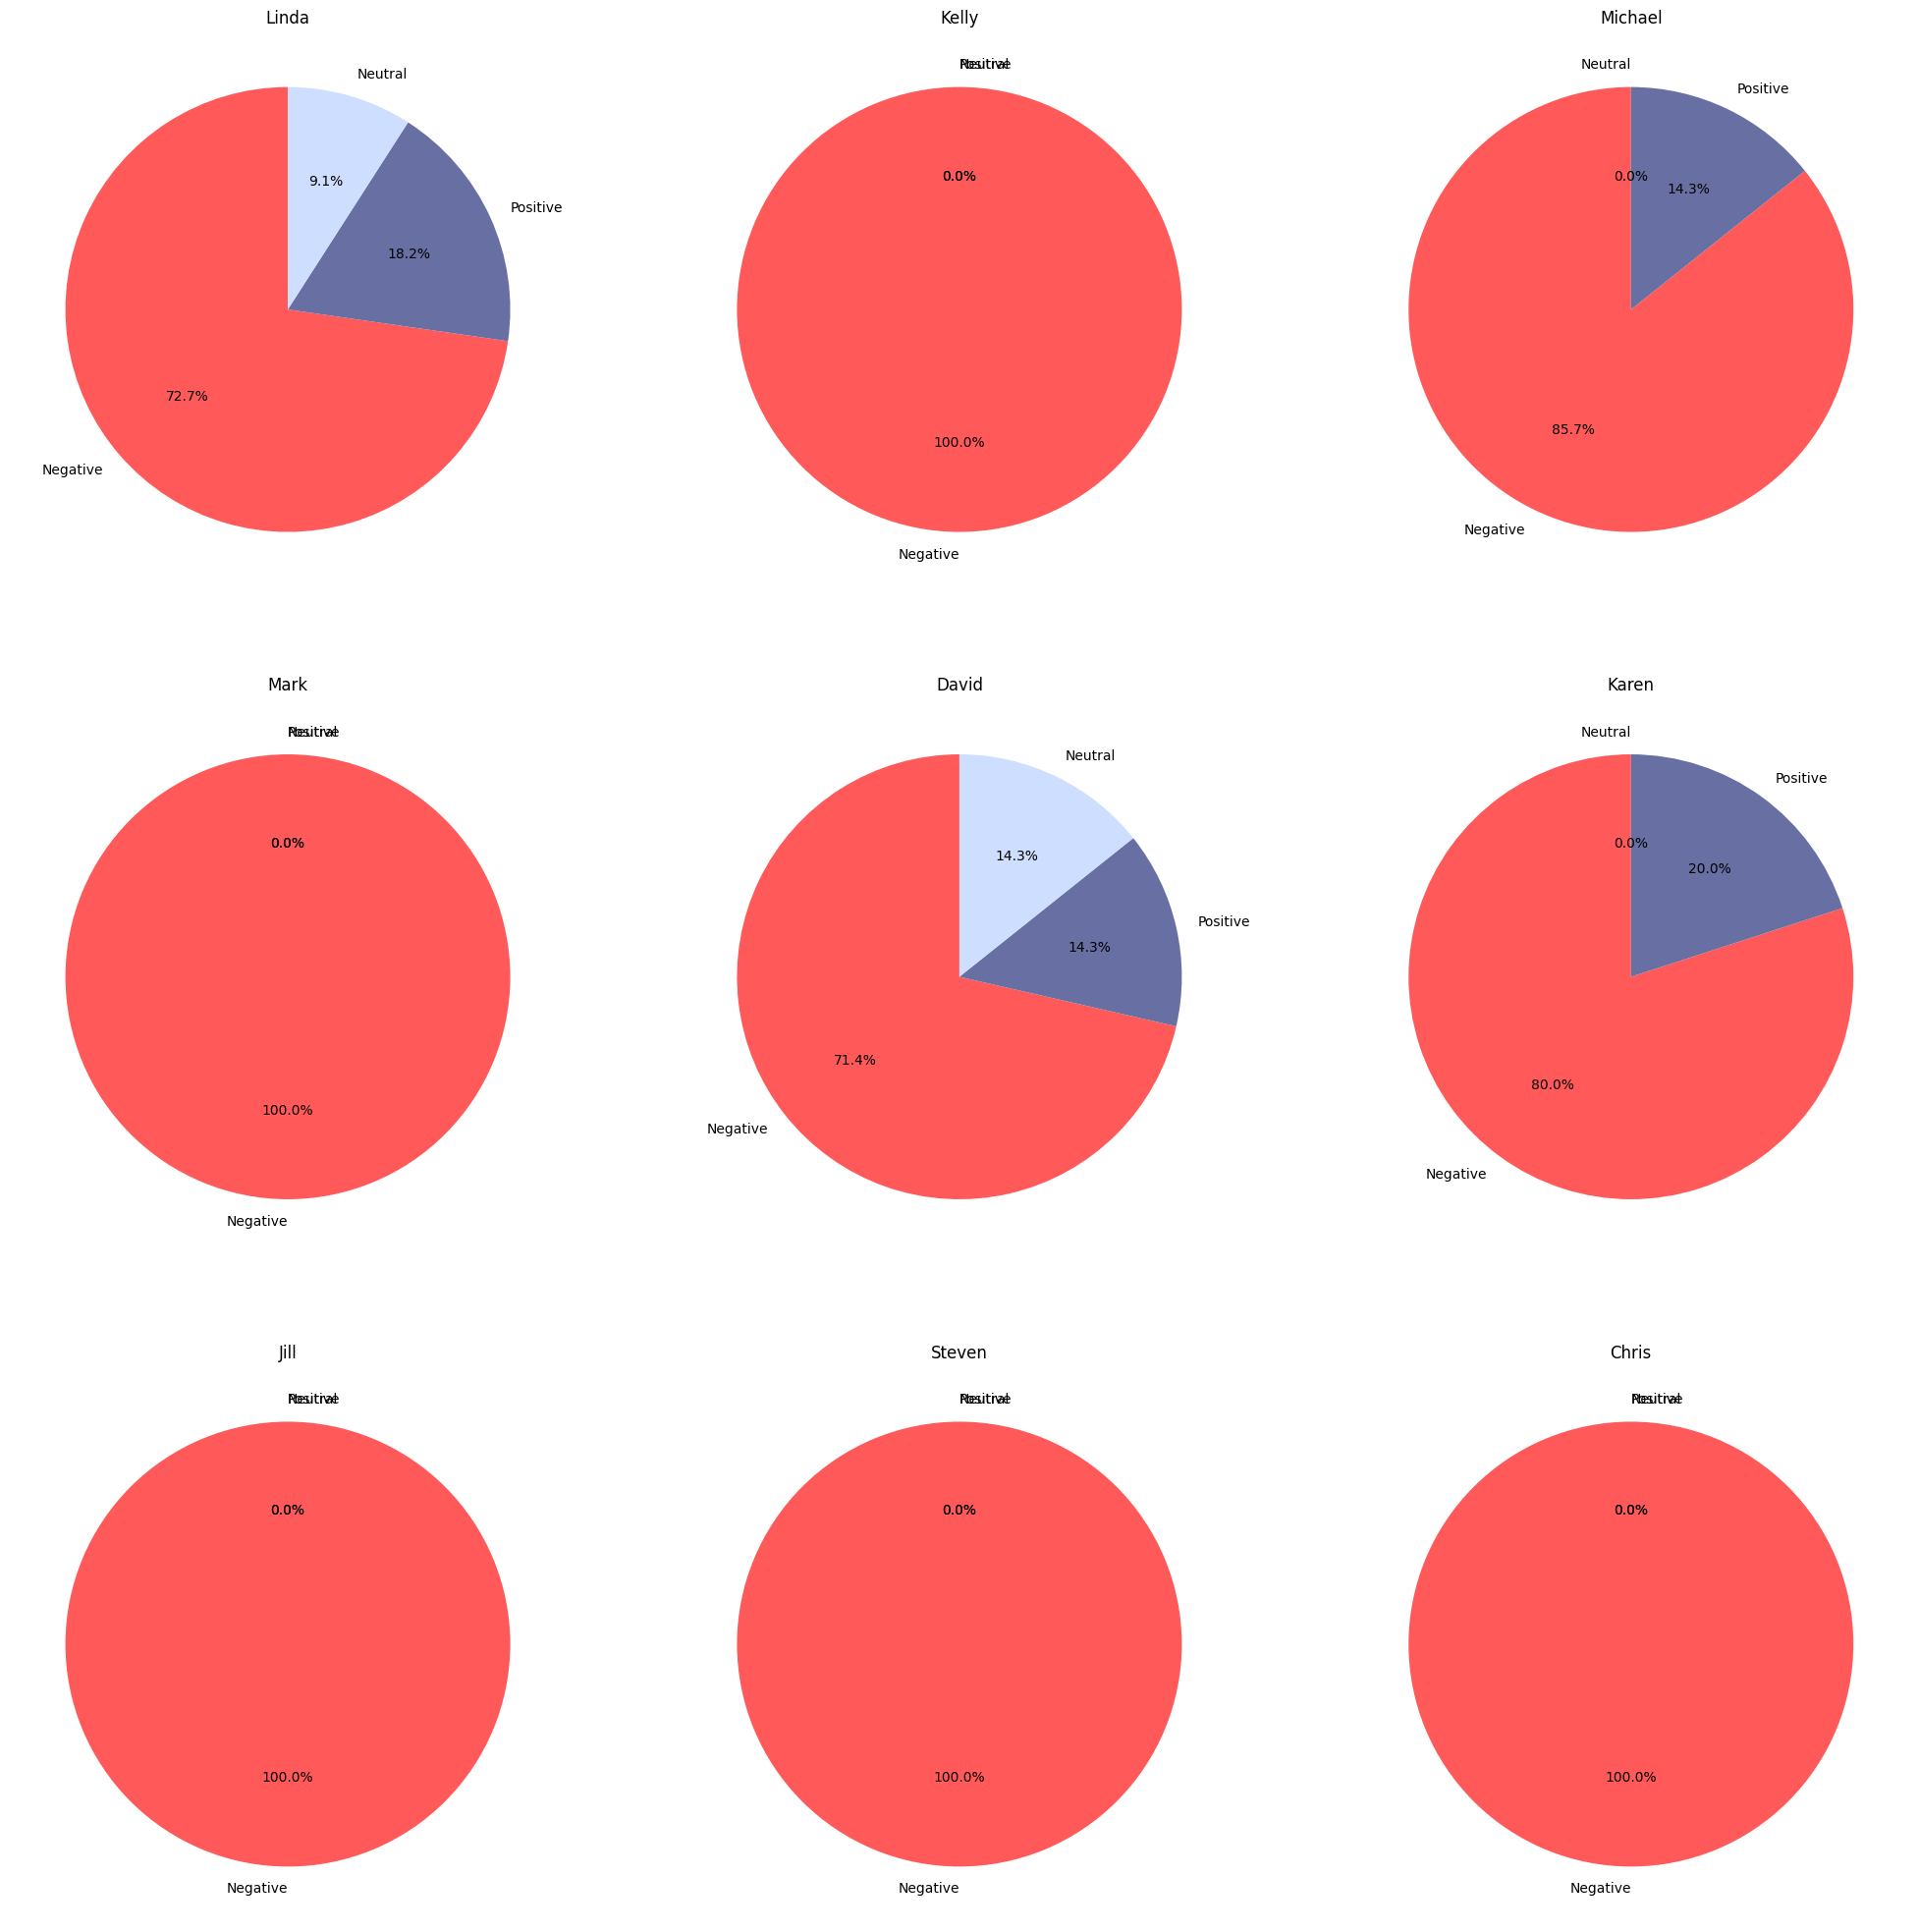

In [21]:
# ploting pie graphs of the names and ratings

plt.figure(figsize=(25,25))
i=1
features = df.index# takes the index(first column of the dataframe df and stores it in features)
# we can then iterate over the names (features) to make pie charts
for x in features:
    plt.subplot(3,3,i)
    ax = plt.pie(df.loc[x],labels=df.columns,autopct='%1.1f%%',startangle=90,
                colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x),loc='center')
    i+=1



- we can see that most of the popular names have negative reviews , 

### 4. Date

- spliting the date into 3: day of the week,month, year 

In [22]:
# This performs a case-insensitive and non-regex to the date
data['Date'] = data['Date'].str.replace('Reviewed',"",case=False,regex='False')
data=data.astype({'Date':'datetime64[ns]'})
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['DayOfWeek'] = data['Date'].dt.dayofweek

### 4.1 month

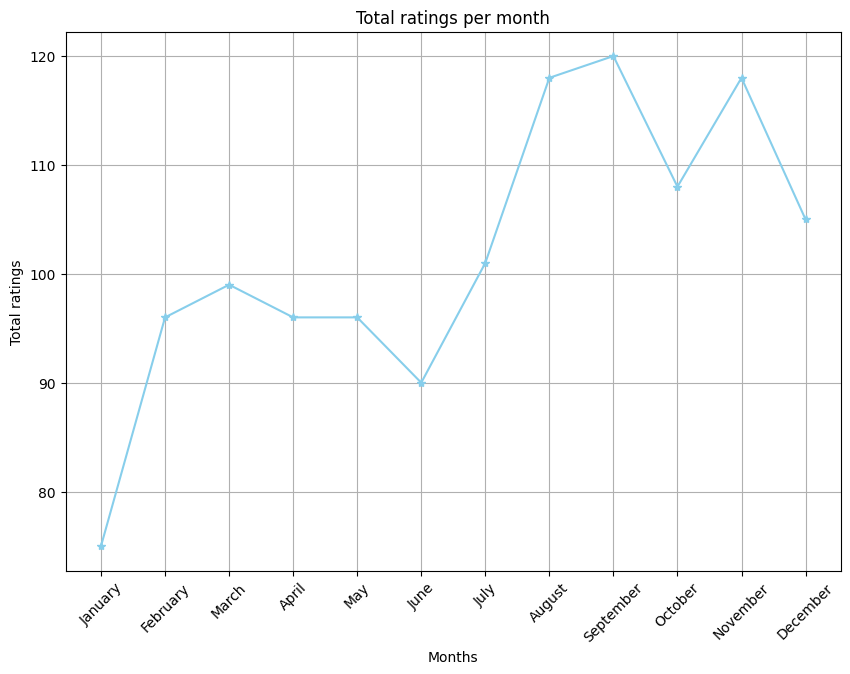

In [26]:
df = data.groupby(['Month'])['Rating'].sum().reset_index()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(10,7))
plt.plot(df['Month'],df['Rating'],marker='*',color='skyblue',linestyle='-')
plt.xlabel('Months')
plt.ylabel('Total ratings')
plt.title('Total ratings per month')

plt.xticks(df['Month'],labels=month_order,rotation=45)
plt.grid(True)


- From July to the end of the year(s) we find that there are many ratings

### 4.2. Year

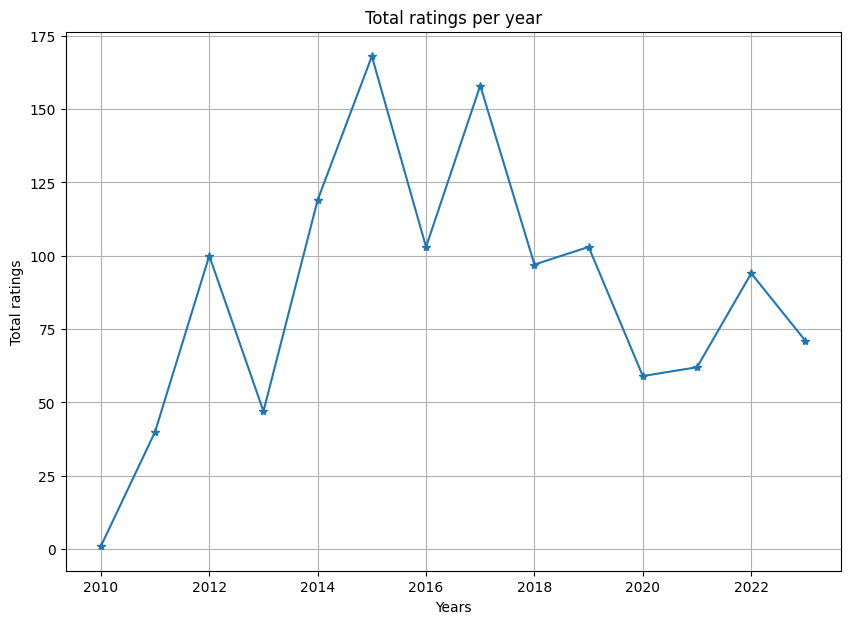

In [31]:
df = data.groupby(data['Year'])['Rating'].sum().reset_index()

plt.figure(figsize=(10,7))
plt.plot(df['Year'],df['Rating'],marker="*",linestyle='-')
plt.xlabel('Years')
plt.ylabel('Total ratings')
plt.title('Total ratings per year')

plt.grid(True)

- Towards 2014 the ratings per year started to increase until 2019,
- in 2019 there was almost an exponetial decay due to the drop in ratings 

### 44.3 :Pie charts for Month/Rating

In [46]:
df = data[["Month","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("Month").count()

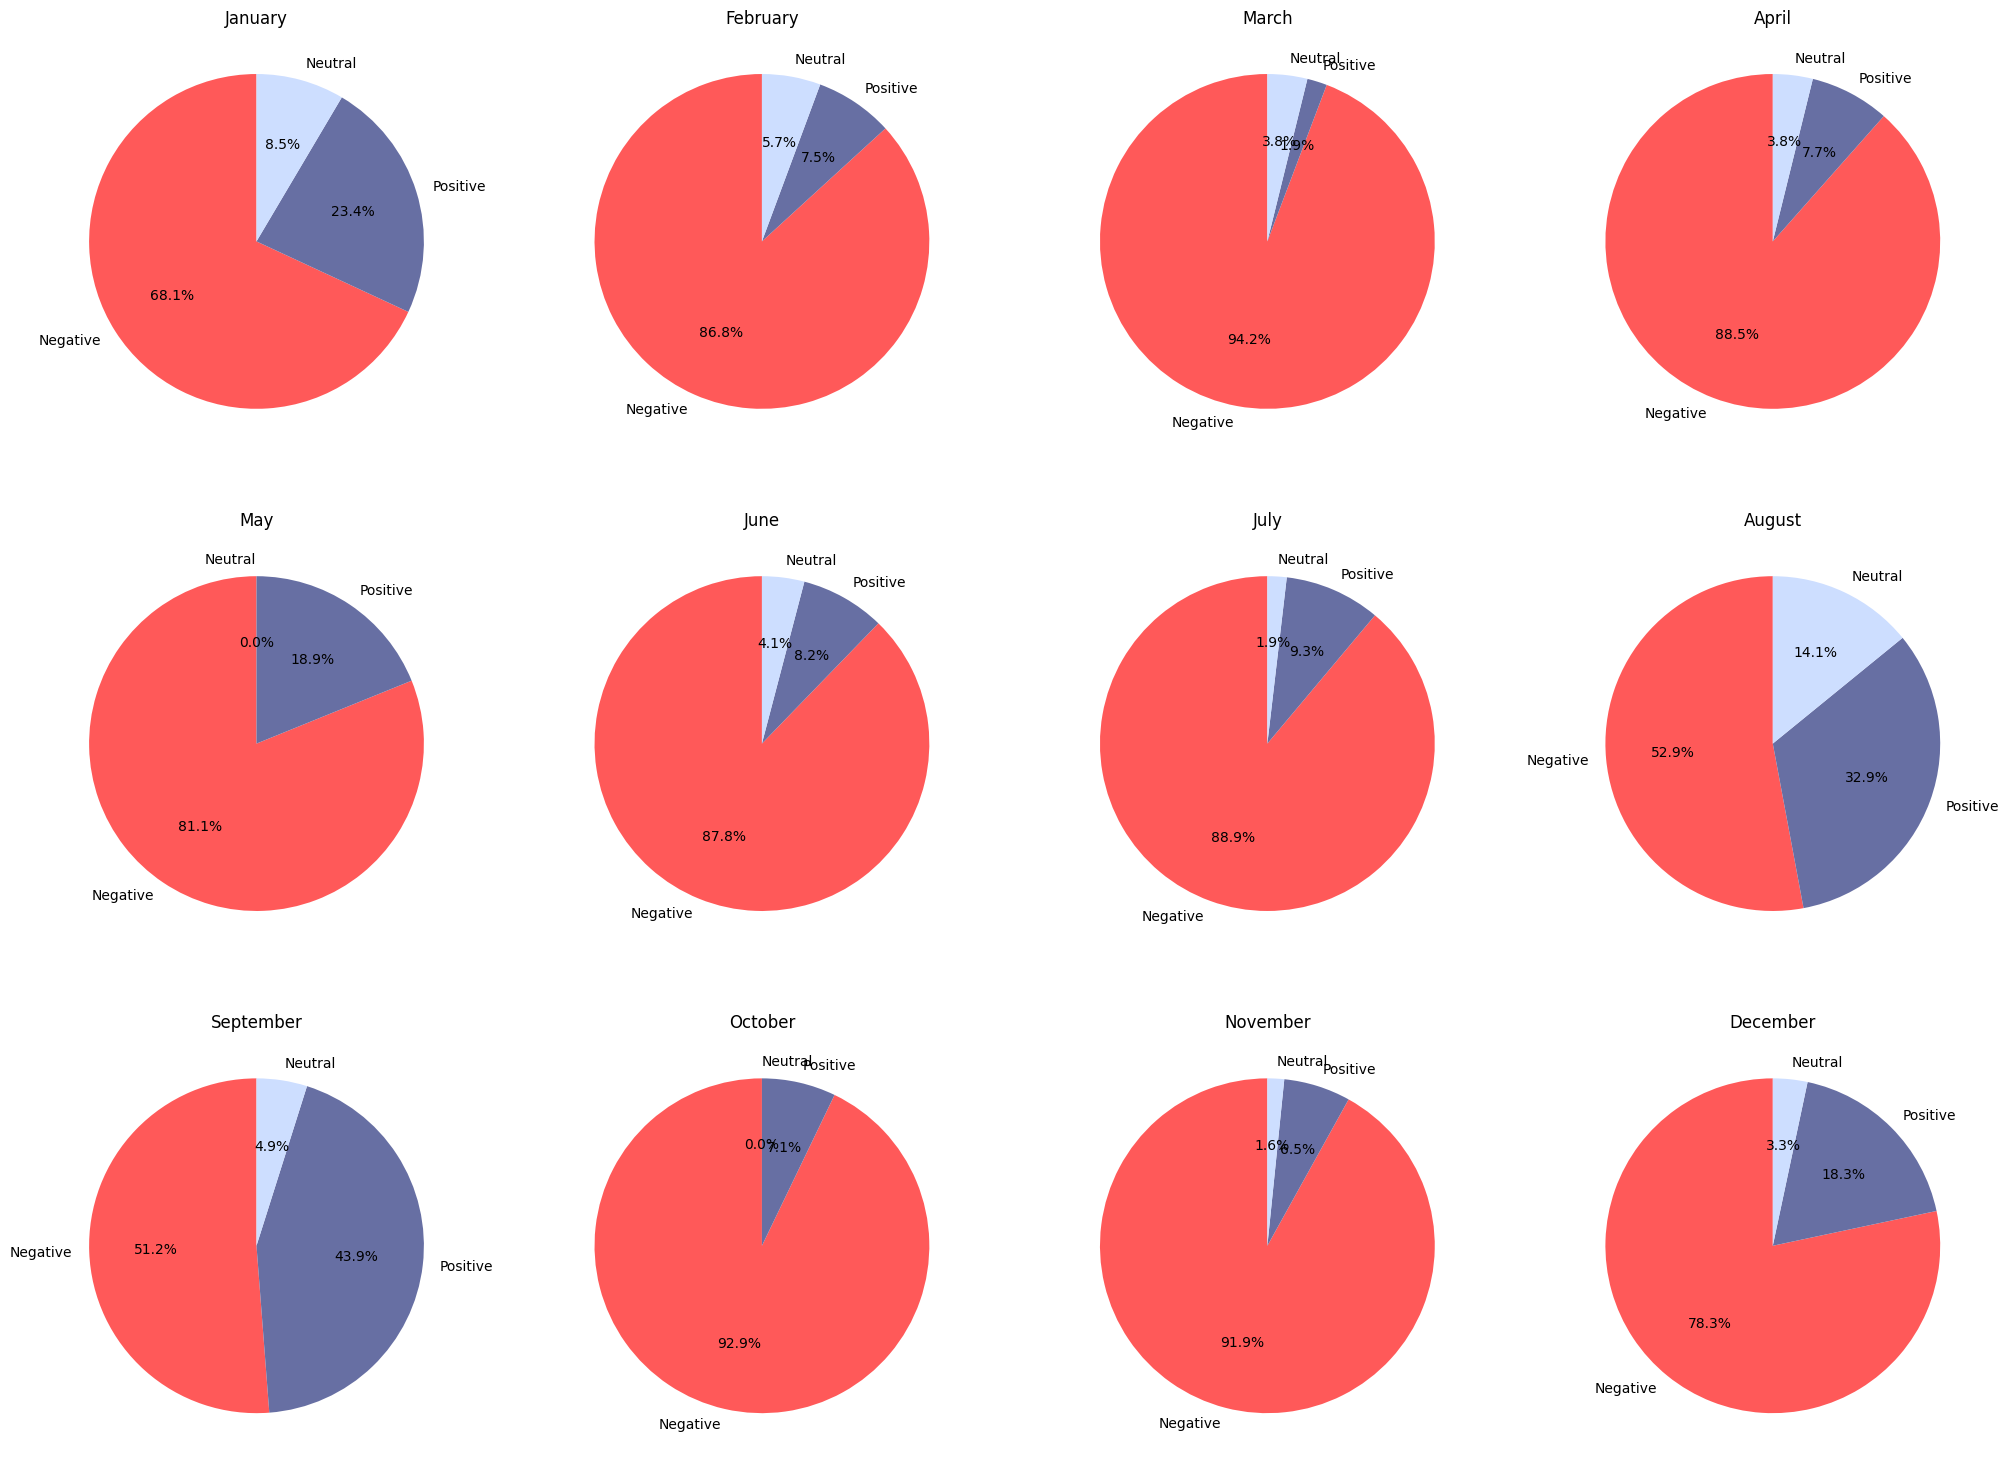

In [48]:
# plot the pie charts for the months 

# make sure we have the figure size 

fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(4,4, i)
    ax=plt.pie(df.loc[x],
               labels=df.columns, 
               autopct='%1.1f%%', 
               startangle=90,
              colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(month_order[x-1], loc='center')
    i+=1
plt.show()

### Year/Rating 

In [53]:
df = data[["Year","Rating"]]
df["Negative"] = df[df["Rating"]==2]["Rating"]
df["Positive"] = df[df["Rating"]==1]["Rating"]
df["Neutral"] = df[df["Rating"]==0]["Rating"]
df.drop("Rating",axis=1,inplace=True)
df=df.groupby("Year").count()[1:]# slicing 2010 since it had one entry only 
df

,Negative,Positive,Neutral
Year,,,
2011,20,0,1
2012,49,2,1
2013,23,1,0
2014,58,3,3
2015,82,4,4
2016,48,7,5
2017,47,64,13
2018,42,13,0
2019,48,7,0


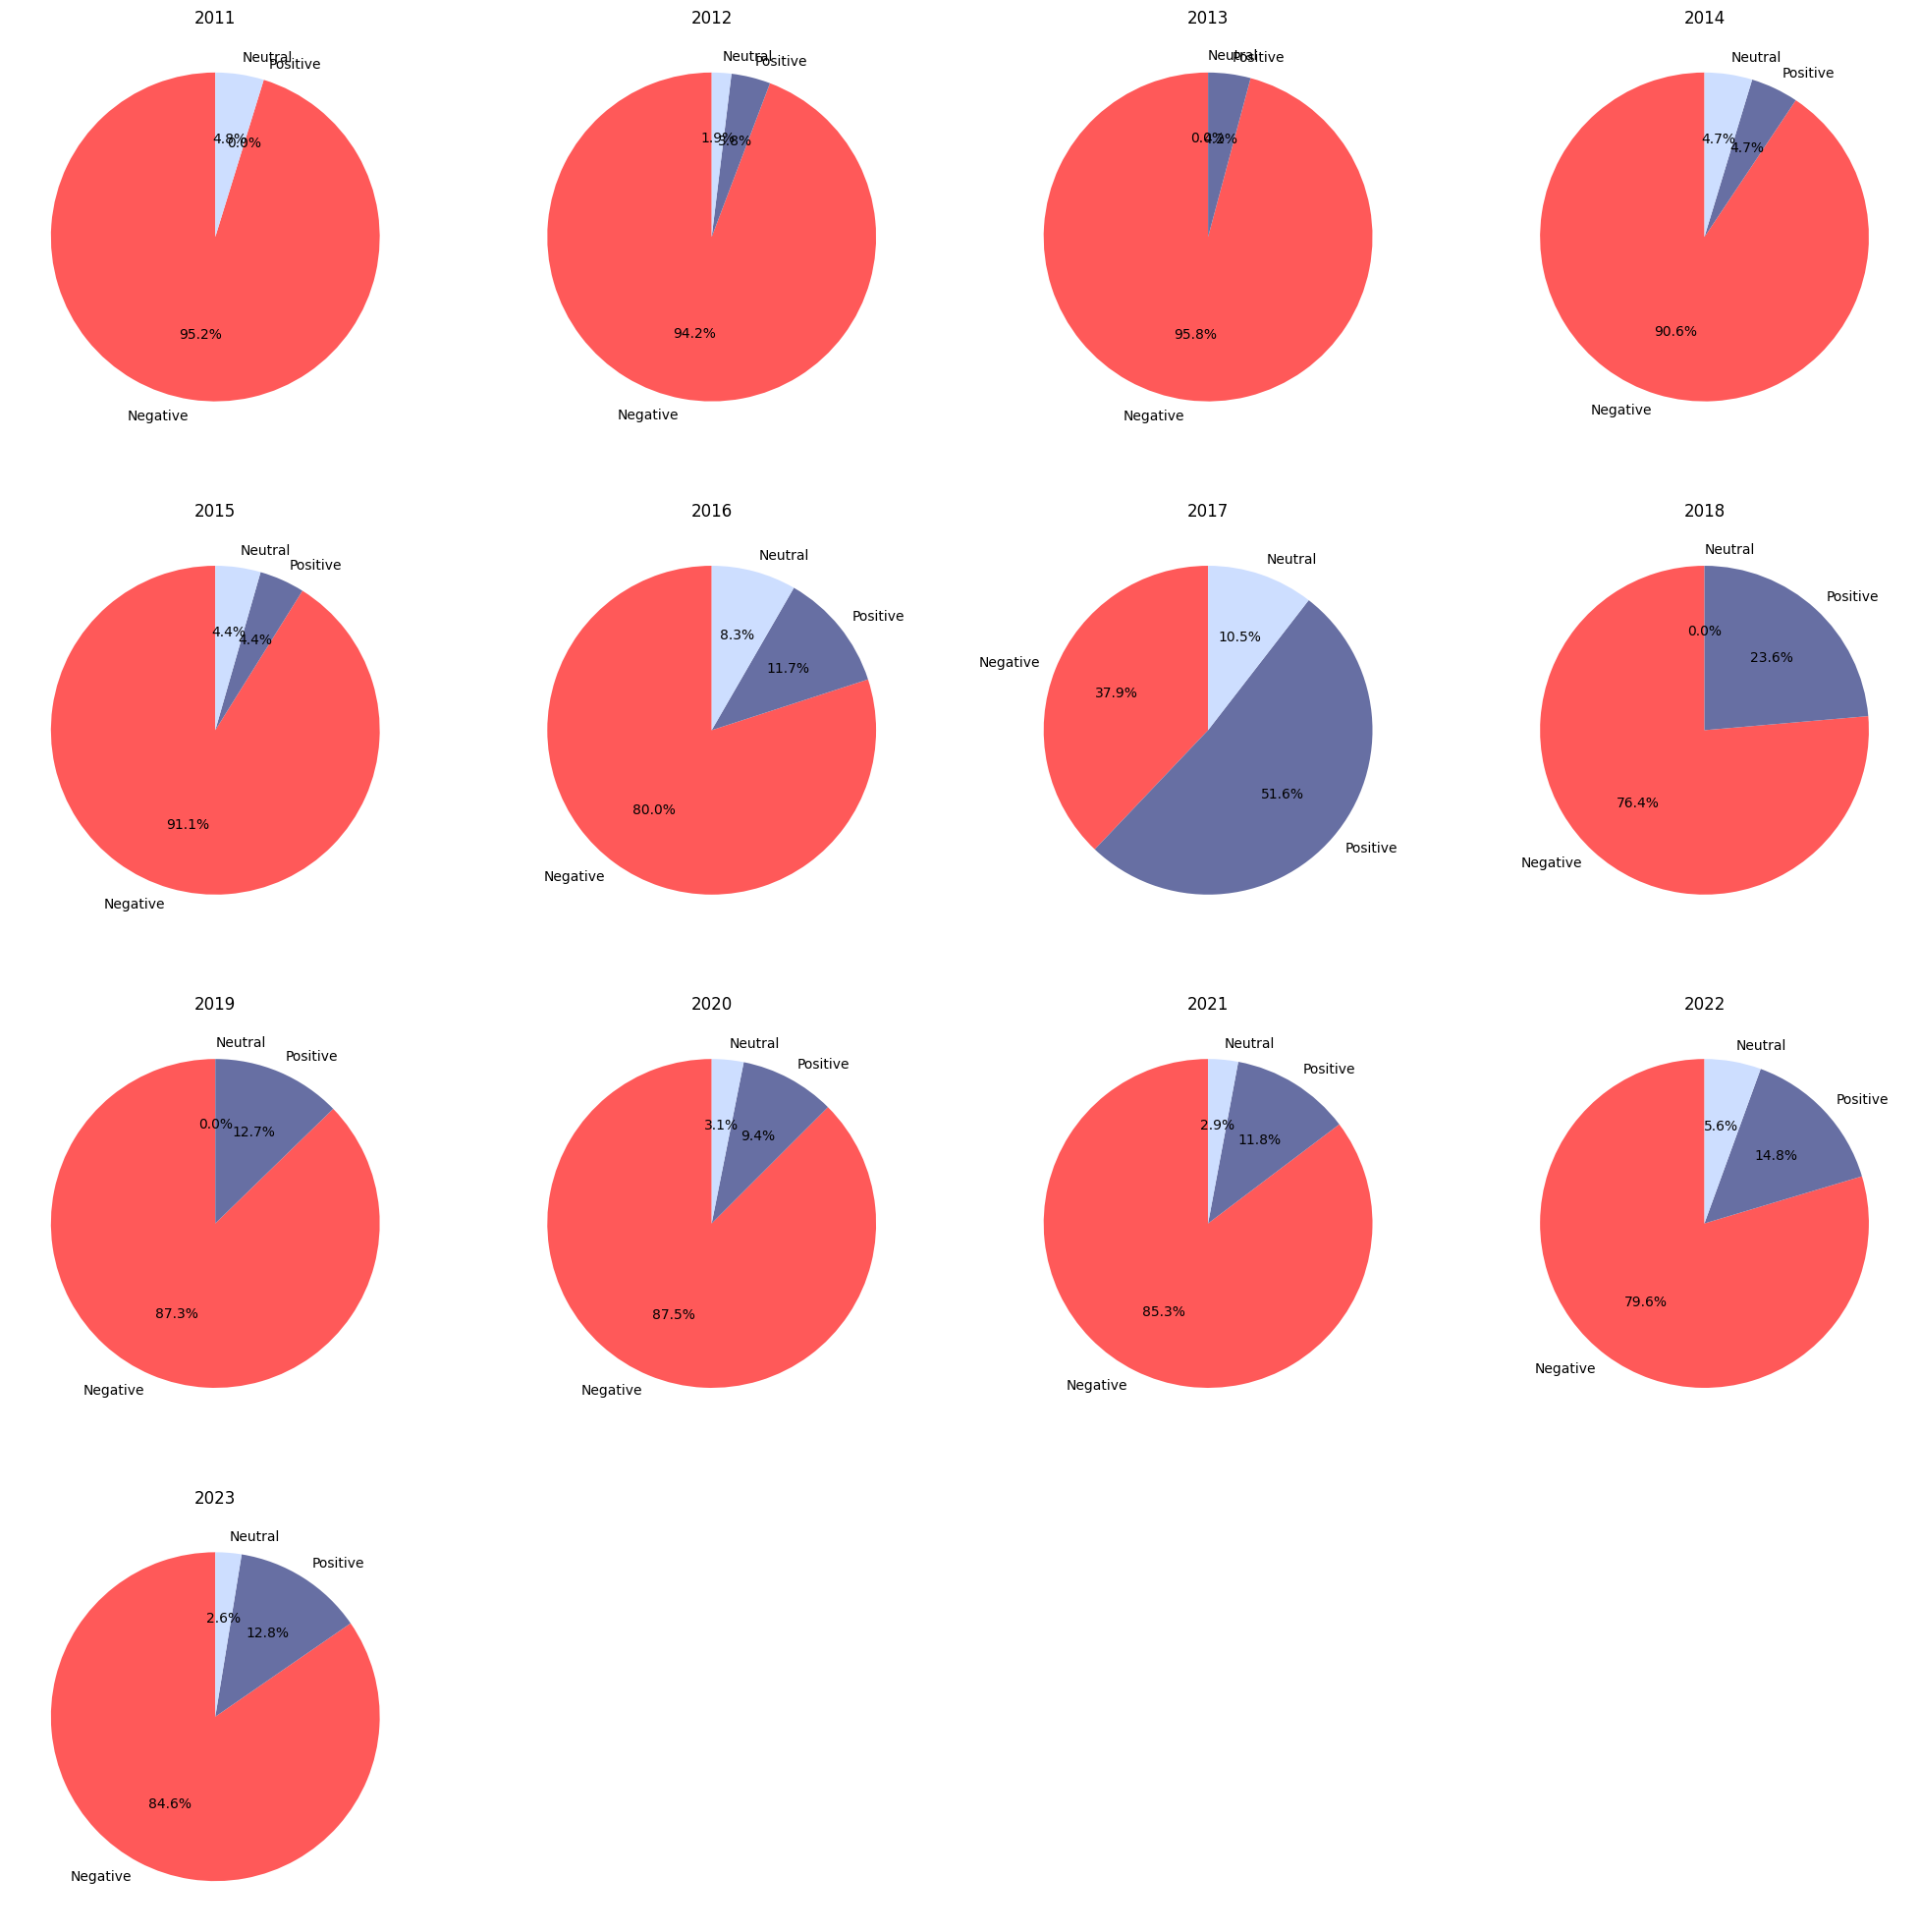

In [54]:
fig = plt.figure(figsize = (25, 25))
i=1
features = df.index
for x in features:
    plt.subplot(4, 4, i)
    ax=plt.pie(df.loc[x], labels=df.columns, autopct='%1.1f%%', startangle=90,
        colors=['#FF5959', '#676FA3','#CDDEFF'])
    plt.title(str(x), loc='center')
    i+=1
plt.show()

- The year 2017 was full of positive reviews 

## summary for EDA 

- It can be seen that most of the reviews came from CA(California).
- Considering states, 4 of the negative ratings are from the east coast in the states of Georgia,North carolina,New york and Florida,
- 2 are on the west coast in the states of Washington and California.
- we saw that most of the popular names have negative reviews.
- From July to the end of the year(s) we find that there are many ratings
- also August and september have the highest positive ratings of any month with 33% and 43% respectively
- Finaly the year 2017 was full of positive ratings compared to the other years with a positive rating percentage of 52% 

## Part 2: 